In [1]:
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import time

# Task
Approximate
$$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi) - (\cfrac{\partial\lambda}{\partial\chi})^n
$$
where
- $\lambda$ - dimensionless river elevation
- $\tau$ - dimensionless time
- $\chi$ - dimensionless distance
- $\nu$ - dimensionless uplift rate
- $n$ - slope exponent

And there are border and initial functions: $\lambda(0, \tau)$, $\lambda(\chi, 0)$

# Define the parameters

In [2]:
dtau = 0.02
ntau = np.ceil(3/dtau).astype(int) + 1
dchi = 0.02
nchi = np.ceil(2/dchi).astype(int) + 1

nu = lambda tau, chi: 1
initial = lambda chi: chi**2
border = lambda tau: 0*tau

ns = [2, 1, 0.5]

# The simpliest approximation $O(d\tau +d\chi^{min(1, n)})$

$$
\cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi) - (\cfrac{\partial\lambda}{\partial\chi})^n
$$

We will use $s$ as a $\tau$ step, and $h$ as a $\chi$ step.
Let's use the notation
$$
\lambda_k^j = \lambda(js, kh)
$$
and the similary:
$$
\nu^j = \nu(js, kh)
$$

The simpliest scheme contains the forward derivative over $\tau$ and backward derivative over $\chi$:
$$
\cfrac{\lambda^{j+1}_k - \lambda^j_k}{s} = \nu^j_k - (\cfrac{\lambda^j_{k-1} - \lambda^j_k}{h})^n
$$
$$
\lambda^{j+1}_k = \lambda^j_k + s\cdot\nu^j_k - s(\cfrac{\lambda^j_{k-1} - \lambda^j_k}{h})^n
$$

In [3]:
def approx1(nu, initial, border, n=1.0, dtau=1e-3, dchi=1e-3, ntau=200, nchi=1000):
    """
    Returns the solution of equation
    $$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\chi, \tau) - (\cfrac{\partial\lambda}{\partial\chi})^n
    $$
    using difference scheme:
    $$
    L_i^{j+1} = L_i^j + d\tau\cdot\nu(i\cdot d\chi, j\cdot d\tau) + d\tau\cdot(\cfrac{L_i^j - L_{i-1}^j}{d\chi})^n
    $$
    
    Parameters:
    -----------
    nu: function of 2 arguments
    
    initial: function of 1 argument
        lambda(chi) for tau = 0
        
    border: function of 1 argument
        lambda(tau), for chi = 0
        
    n : float
    
    dtau : float
    
    dchi : float
    
    ntau : int
        Number of tau grid lines
    
    nchi : int
        Number of chi grid lines
    
    Returns:
    --------
    sols: np.array shape (ntau, nchi)
        Solutions
    
    taus: np.array shape (ntau)
        tau values
        
    chis: np.array shape (nchis)
        chi values
    """
    taus = dtau*np.arange(ntau)
    chis = dchi*np.arange(nchi)
    
    sols = np.zeros([ntau, nchi])
    try:
        sols[0, :] = initial(chis)
    except TypeError:
        sols[0, :] = [initial(chi) for chi in chis]
    try:
        sols[:, 0] = border(taus)
    except TypeError:
        sols[:, 0] = [border(tau) for tau in taus]
    
    for j in range(ntau - 1):
        jnus = np.array([nu(j*dtau, chi) for chi in chis[1:]]) # should add a condition to nu taking array arguments
        sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n
            
    return sols, taus, chis

In [4]:
sols = []
for n in ns:
    timer = time.perf_counter()
    sol, taus, chis = approx1(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi)
    timer = time.perf_counter() - timer
    print('For solution n={0:.1f} calculated in {1:.4f} seconds.'.format(n, timer))
    sols.append(sol.copy())

sols = np.array(sols)
sols.shape

For solution n=2.0 calculated in 0.0074 seconds.
For solution n=1.0 calculated in 0.0063 seconds.
For solution n=0.5 calculated in 0.0065 seconds.


/tmp/ipykernel_56649/2523524694.py:60: RuntimeWarning: overflow encountered in square
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n
/tmp/ipykernel_56649/2523524694.py:60: RuntimeWarning: invalid value encountered in subtract
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n
/tmp/ipykernel_56649/2523524694.py:60: RuntimeWarning: invalid value encountered in sqrt
  sols[j+1, 1:] = sols[j, 1:] + dtau*jnus - dtau*((sols[j, 1:] - sols[j, :-1])/dchi)**n


(3, 151, 101)

/usr/lib64/python3.11/site-packages/mpl_toolkits/mplot3d/art3d.py:1187: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/usr/lib64/python3.11/site-packages/mpl_toolkits/mplot3d/art3d.py:1188: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/usr/lib64/python3.11/site-packages/numpy/core/numeric.py:1665: RuntimeWarning: invalid value encountered in multiply
  multiply(a1, b2, out=cp0)
/usr/lib64/python3.11/site-packages/numpy/core/numeric.py:1666: RuntimeWarning: invalid value encountered in multiply
  tmp = array(a2 * b1)
/usr/lib64/python3.11/site-packages/numpy/core/numeric.py:1667: RuntimeWarning: invalid value encountered in subtract
  cp0 -= tmp
/usr/lib64/python3.11/site-packages/numpy/core/numeric.py:1668: RuntimeWarning: invalid value encountered in multiply
  multiply(a2, b0, out=cp1)
/usr/lib64/python3.11/site-packages/numpy/core/numeric.py:1669: RuntimeWarning: invalid value encountere

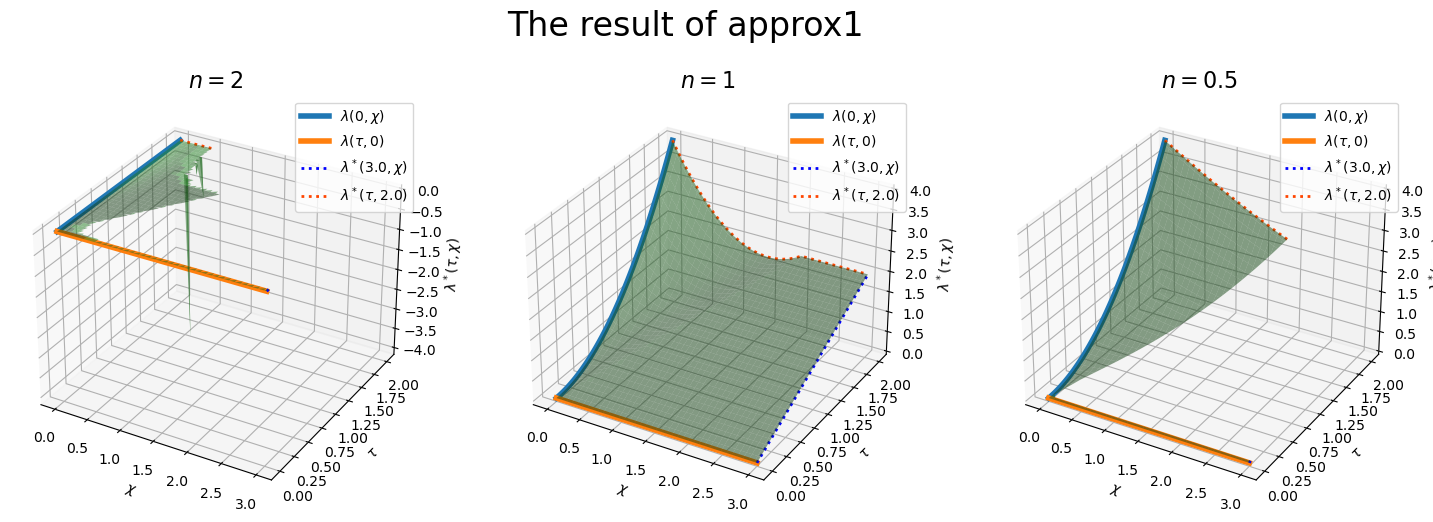

In [5]:
tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

fig, axs = plt.subplots(1, len(sols), subplot_kw={"projection": "3d"})
fig.set_figheight(6)
fig.set_figwidth(6*len(sols))

fig.suptitle(f'The result of {approx1.__name__}', fontsize=24)

for i in range(len(ns)):
    title = f'$n = {ns[i]}$'
    
    axs[i].set_title(title, fontsize=16)
    
    axs[i].plot(0*chis, chis, initial(chis), linewidth=4, label=r'$\lambda(0, \chi)$')
    axs[i].plot(taus, 0*taus, border(taus), linewidth=4, label=r'$\lambda(\tau, 0)$')
    
    axs[i].plot(tau_space[-1, :], chi_space[-1, :], sols[i, -1, :], 
                linestyle=':', linewidth=2, 
                color='blue', label=r'$\lambda^*({0}, \chi)$'.format(tau_space[-1, -1]))
    axs[i].plot(tau_space[:, -1], chi_space[:, -1], sols[i, :, -1], 
                linestyle=':', linewidth=2, 
                color='orangered', label=r'$\lambda^*(\tau, {0})$'.format(chi_space[-1, -1]))
    
    axs[i].plot_surface(tau_space, chi_space, sols[i], alpha=0.5)
    
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_ylabel(r'$\tau$')
    axs[i].set_zlabel(r'$\lambda^*(\tau, \chi)$')
    axs[i].legend()

# Jean Braun, Sean D. Willetts

The previous scheme was totally unstable. but there is an Jean Braun, Sean D. Willetts [article](https://www.sciencedirect.com/science/article/abs/pii/S0169555X12004618) with modificated similar scheme.

## Equation
This scheme should approximate the equation:
$$
    \cfrac{\partial h}{\partial t} = -KA^m(\cfrac{\partial h}{\partial x})^n
$$
in our language it will be
$$
    \cfrac{\partial\lambda}{\partial\tau} = -KA^m(\cfrac{\partial\lambda}{\partial\chi})^n
$$

So it's just an another equation than ours
$$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi) - (\cfrac{\partial\lambda}{\partial\chi})^n
$$

To compare this scheme with ours, let's set $\nu = 0$ and $KA^m = 1$ ($K=1, A=1, m=0$)
$$
    \cfrac{\partial\lambda}{\partial\tau} + (\cfrac{\partial\lambda}{\partial\chi})^n = 0
$$

Let's check how stable our scheme is when $\nu(\chi, \tau) = 0$

## Scheme
I'll describe the scheme using both notations: mine and the article outors.

The first author defines a simple first-order finite difference schemes to compute both the spatial derivative (the slope) of the height field and its time derivative:
$$
    \cfrac{\partial h(i)}{\partial x} = \cfrac{h^{t}(r(i)) - h^{t}(i)}{\Delta x_i}
$$
$$
    \cfrac{\partial h(i)}{\partial t} = \cfrac{h^{t + \Delta t}(i) - h^{t}(i)}{\Delta t}
$$
In our notation this will be:
$$
{\cfrac{\partial\lambda}{\partial\tau}}_k^j = 
\cfrac{\lambda_k^{j+1} - \lambda_k^j}{s} 
$$
$$
{\cfrac{\partial\lambda}{\partial\chi}}_k^j = 
\cfrac{\lambda_{k+1}^j - \lambda_k^j}{h} 
$$

Jean Braun and Sean D. Willett do not calculate the value in middle grid poin, as I am going to do later, and represent the scheme by 2 derivatives near new point:
$$
\cfrac{h^{t+\Delta t}(s(i)) - h^{t}(s(i))}{\Delta t} = 
-KA^m(\cfrac{h^{t+\Delta t}(s(i)) - h^{t+\Delta t}(r(s(i)))}{\Delta x_i})^n
$$
In our notation this will be:
$$
\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1}}{s} = 
-KA^m(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n
$$
and then authors get the value $\lambda^{j+1}_{k+1}$ by solving nonlinear equation:
$$
h^{t+\Delta t}(s(i)) - h^t(s(i)) + KA^m\Delta t(\cfrac{h^{t+\Delta t}(s(i)) - h^{t+\Delta t}(r(s(i)))}{\Delta x_i})^n = 0
$$
in our notation:
$$
F(\lambda^{j+1}_{k+1}) = 
\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1} + KA^m\cdot s(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n = 0
$$
and it's derivative is
$$
\cfrac{\partial F}{\partial \lambda^{j+1}_{k+1}} (\lambda^{j+1}_{k+1}) = 
1 + KA^m\cdot\cfrac{s}{h}(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^{n-1}
$$

In [6]:
pass

# Nonlinear approximation $O(d\tau +d\chi^{min(1, n)})$

Let's make the same representation, as Braun and Willet did:
$$
\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1}}{s} = \nu^{j+1}_{k+1} - (
\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n
$$

To find the approximation of $\lambda^{j+1}_{k+1}$ we should solve a nonlinear equation $F(\lambda^{j+1}_{k+1}) = 0$ where
$$
F(\lambda^{j+1}_{k+1}) = \lambda^{j+1}_{k+1} - \lambda^{j}_{k+1} + 
s(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n - s\nu^{j+1}_{k+1}
$$
and
$$
\cfrac{\partial F}{\partial \lambda^{j+1}_{k+1}}(\lambda^{j+1}_{k+1}) = 
1 - \cfrac{s}{h}(\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^{n-1}
$$

In [7]:
def approx1nonlinear(nu, initial, border, n=1.0, dtau=1e-3, dchi=1e-3, ntau=200, nchi=1000, 
                     method=sp.optimize.fsolve, use_fprime=True, bar=None):
    """
    Returns the solution of equation
    $$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\chi, \tau) - (\cfrac{\partial\lambda}{\partial\chi})^n
    $$
    using difference scheme:
    $$
    \cfrac{\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1}}{s} = \nu^{j+1}_{k+1} - (
    \cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k}}{h})^n
    $$
    
    Parameters:
    -----------
    nu: function of 2 arguments
    
    initial: function of 1 argument
        lambda(chi) for tau = 0
        
    border: function of 1 argument
        lambda(tau), for chi = 0
        
    n : float
    
    dtau : float
    
    dchi : float
    
    ntau : int
        Number of tau grid lines
    
    nchi : int
        Number of chi grid lines
    
    method : function
        Method to solve nonlinear equation
        
    use_fprime : bool
        Use an analytical derivative as fprime parameter in method
        
    bar: tqdm bar or None:
        bar to update each iteration.
        Not draw bar if it's None
        
    Returns:
    --------
    sols: np.array shape (ntau, nchi)
        Solutions
    
    taus: np.array shape (ntau)
        tau values
        
    chis: np.array shape (nchis)
        chi values
    """
    taus = dtau*np.arange(ntau)
    chis = dchi*np.arange(nchi)
    
    sols = np.zeros([ntau, nchi])
    try:
        sols[0, :] = initial(chis)
    except TypeError:
        sols[0, :] = [initial(chi) for chi in chis]
    try:
        sols[:, 0] = border(taus)
    except TypeError:
        sols[:, 0] = [border(tau) for tau in taus]
    
    for j in range(ntau - 1):
        for k in range(nchi - 1):
            f = lambda sol: sol - sols[j, k+1] + dtau*((sol - sols[j+1, k])/dchi)**n - dtau*nu((j+1)*dtau, (k+1)*dchi)
            if use_fprime:
                fprime = lambda sol: 1 - (dtau/dchi)*((sol - sols[j+1, k])/dchi)**(n - 1)
                sols[j+1, k+1] = method(f, x0=sols[j, k], fprime=fprime)
            else:
                sols[j+1, k+1] = method(f, x0=sols[j, k]) 
            if bar is not None:
                bar.update()
    return sols, taus, chis

In [8]:
sols = []
for n in ns:
    print(f'Approximating over grid for n = {n}')
    with tqdm(total=(ntau - 1)*(nchi - 1)) as pbar:
        sol, taus, chis = approx1nonlinear(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, bar=pbar)
    sols.append(sol.copy())

sols = np.array(sols)
sols.shape

Approximating over grid for n = 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Approximating over grid for n = 1


/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/lib64/python3.11/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


  0%|          | 0/15000 [00:00<?, ?it/s]

Approximating over grid for n = 0.5


  0%|          | 0/15000 [00:00<?, ?it/s]

/tmp/ipykernel_56649/2679813766.py:74: RuntimeWarning: divide by zero encountered in power
  fprime = lambda sol: 1 - (dtau/dchi)*((sol - sols[j+1, k])/dchi)**(n - 1)
/tmp/ipykernel_56649/2679813766.py:72: RuntimeWarning: invalid value encountered in sqrt
  f = lambda sol: sol - sols[j, k+1] + dtau*((sol - sols[j+1, k])/dchi)**n - dtau*nu((j+1)*dtau, (k+1)*dchi)


(3, 151, 101)

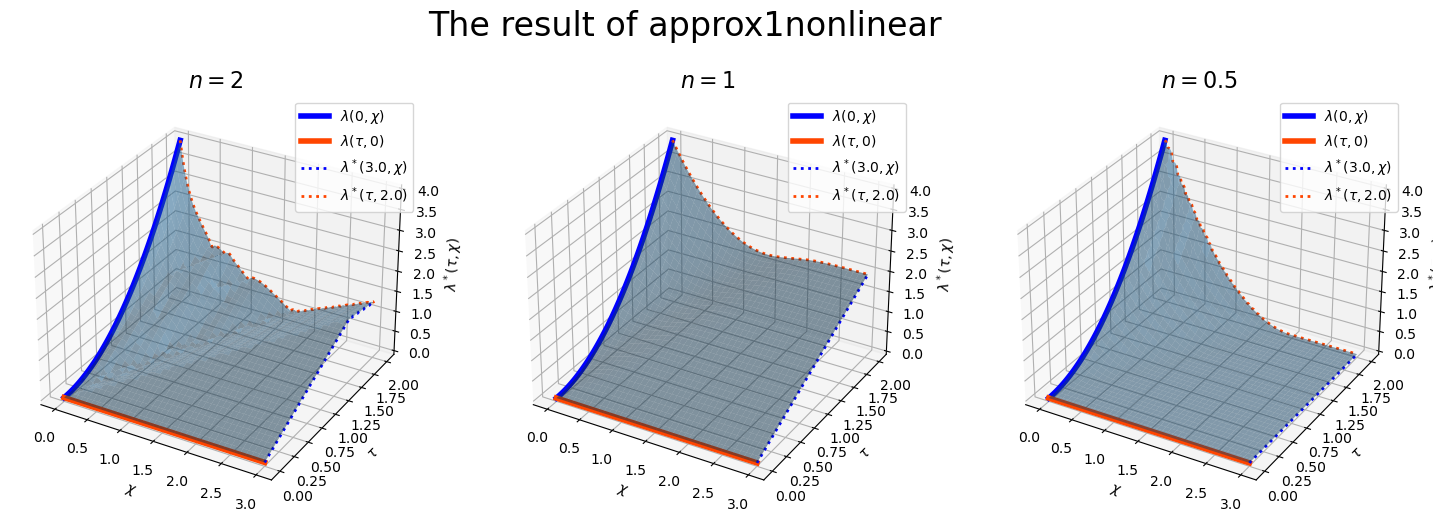

In [9]:
tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

fig, axs = plt.subplots(1, len(sols), subplot_kw={"projection": "3d"})
fig.set_figheight(6)
fig.set_figwidth(6*len(sols))

fig.suptitle(f'The result of {approx1nonlinear.__name__}', fontsize=24)

for i in range(len(ns)):
    title = f'$n = {ns[i]}$'
    
    axs[i].set_title(title, fontsize=16)
    
    axs[i].plot(0*chis, chis, initial(chis), linewidth=4, color='blue', label=r'$\lambda(0, \chi)$')
    axs[i].plot(taus, 0*taus, border(taus), linewidth=4, color='orangered', label=r'$\lambda(\tau, 0)$')
    
    axs[i].plot(tau_space[-1, :], chi_space[-1, :], sols[i, -1, :], 
                linestyle=':', linewidth=2, 
                color='blue', label=r'$\lambda^*({0}, \chi)$'.format(tau_space[-1, -1]))
    axs[i].plot(tau_space[:, -1], chi_space[:, -1], sols[i, :, -1], 
                linestyle=':', linewidth=2, 
                color='orangered', label=r'$\lambda^*(\tau, {0})$'.format(chi_space[-1, -1]))
    
    axs[i].plot_surface(tau_space, chi_space, sols[i], alpha=0.5)
    
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_ylabel(r'$\tau$')
    axs[i].set_zlabel(r'$\lambda^*(\tau, \chi)$')
    axs[i].legend()

# Approximation by nonlinear way $O(d\tau^{min(2, 3n)} +d\chi^{min(2, 2n)})$

$$
\cfrac{\partial\lambda}{\partial\tau} = \nu(\tau, \chi) - (\cfrac{\partial\lambda}{\partial\chi})^n
$$

We will use $s$ as a $\tau$ step, and $h$ as a $\chi$ step.
Let's use the notation
$$
\lambda_k^j = \lambda(js, kh)
$$
and the similary:
$$
\nu^j = \nu(js, kh)
$$
$$
\cfrac{\partial\lambda}{\partial\tau}_k^j = \cfrac{\partial\lambda}{\partial\tau}(js, kh)
$$
$$
\cfrac{\partial^2\lambda}{\partial\tau^2}_k^j = \cfrac{\partial^2\lambda}{\partial\tau^2}(js, kh)
$$
$$
\cfrac{\partial\lambda}{\partial\chi}_k^j = \cfrac{\partial\lambda}{\partial\chi}(js, kh)
$$
$$
\cfrac{\partial^2\lambda}{\partial\chi^2}_k^j = \cfrac{\partial^2\lambda}{\partial\chi^2}(js, kh)
$$

Now let's represent $\lambda^{j+1}_{k+1}$, $\lambda^{j+1}_{k+1}$, $\lambda^{j+1}_{k+1}$ and $\lambda^{j+1}_{k+1}$ in the terms of Taylor series near point $((j+0.5)s, (k+0.5)h)$:
$$
\lambda^{j+1}_{k+1} = 
\lambda^{j+0.5}_{k+0.5} + 
\cfrac{s}{2}{\cfrac{\partial\lambda}{\partial\tau}}^{j+0.5}_{k+0.5} + 
\cfrac{h}{2}{\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{s^2}{8}{\cfrac{\partial^2\lambda}{\partial\tau^2}}^{j+0.5}_{k+0.5} + 
\cfrac{sh}{4}{\cfrac{\partial^2\lambda}{\partial\tau\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{h^2}{8}{\cfrac{\partial^2\lambda}{\partial\chi^2}}^{j+0.5}_{k+0.5} + 
O(s^3 + h^3)
$$
$$
\lambda^{j+1}_{k} = 
\lambda^{j+0.5}_{k+0.5} + 
\cfrac{s}{2}{\cfrac{\partial\lambda}{\partial\tau}}^{j+0.5}_{k+0.5} -
\cfrac{h}{2}{\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{s^2}{8}{\cfrac{\partial^2\lambda}{\partial\tau^2}}^{j+0.5}_{k+0.5} -
\cfrac{sh}{4}{\cfrac{\partial^2\lambda}{\partial\tau\chi}}^{j+0.5}_{k+0.5} +
\cfrac{h^2}{8}{\cfrac{\partial^2\lambda}{\partial\chi^2}}^{j+0.5}_{k+0.5} + 
O(s^3 + h^3)
$$
$$
\lambda^{j}_{k+1} = 
\lambda^{j+0.5}_{k+0.5} -
\cfrac{s}{2}{\cfrac{\partial\lambda}{\partial\tau}}^{j+0.5}_{k+0.5} + 
\cfrac{h}{2}{\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{s^2}{8}{\cfrac{\partial^2\lambda}{\partial\tau^2}}^{j+0.5}_{k+0.5} -
\cfrac{sh}{4}{\cfrac{\partial^2\lambda}{\partial\tau\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{h^2}{8}{\cfrac{\partial^2\lambda}{\partial\chi^2}}^{j+0.5}_{k+0.5} + 
O(s^3 + h^3)
$$
$$
\lambda^{j}_{k} = 
\lambda^{j+0.5}_{k+0.5} -
\cfrac{s}{2}{\cfrac{\partial\lambda}{\partial\tau}}^{j+0.5}_{k+0.5} -
\cfrac{h}{2}{\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{s^2}{8}{\cfrac{\partial^2\lambda}{\partial\tau^2}}^{j+0.5}_{k+0.5} +
\cfrac{sh}{4}{\cfrac{\partial^2\lambda}{\partial\tau\chi}}^{j+0.5}_{k+0.5} + 
\cfrac{h^2}{8}{\cfrac{\partial^2\lambda}{\partial\chi^2}}^{j+0.5}_{k+0.5} + 
O(s^3 + h^3)
$$



We can approximate the derivatives:
$$
\cfrac{\partial\lambda}{\partial\tau}_{k+0.5}^{j+0.5} =
\cfrac{\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j}{2s} + O(s^2 + h^3)
$$

$$
\cfrac{\partial\lambda}{\partial\chi}_{k+0.5}^{j+0.5} =
\cfrac{\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j}{2h} + O(s^3 + h^2)
$$

So we also can approximate:
$$
{\cfrac{\partial\lambda}{\partial\tau}}_{k+0.5}^{j+0.5} + ({\cfrac{\partial\lambda}{\partial\chi}}^{j+0.5}_{k+0.5})^n = 
\cfrac{\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j}{2s} + 
(\cfrac{\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j}{2h})^n + 
O(s^{min(2, 3n)} + h^{min(2, 2n)})
$$

And the scheme will be:
$$
\cfrac{\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j}{2s} + 
(\cfrac{\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j}{2h})^n -
\nu^{j+0.5}_{k+0.5} = 0
$$

And we should solve nonlinear equation $F(\lambda_{k+1}^{j+1}) = 0$ to find an element $\lambda_{k+1}^{j+1}$, where
$$
F(\lambda_{k+1}^{j+1}) = 
\cfrac{\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j}{2s} + 
(\cfrac{\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j}{2h})^n -
\nu^{j+0.5}_{k+0.5}
$$

We can solve this equation using methods like [Newton](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html#scipy.optimize.newton) or any [other](https://docs.scipy.org/doc/scipy/reference/optimize.html#root-finding). I prefer [scipy fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html), cause it's faster. 

And we can use the analytical derivatives for these solving methods:
$$
\cfrac{\partial F}{\partial \lambda_{k+1}^{j+1}}(\lambda_{k+1}^{j+1}) = 
\cfrac{1}{2s} + \cfrac{1}{(2h)^n}\cdot(\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j)^{n-1}
$$
$$
\cfrac{\partial^2 F}{\partial {\lambda_{k+1}^{j+1}}^2}(\lambda_{k+1}^{j+1}) = 
\cfrac{1}{(2h)^n}\cdot(\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j)^{n-2}
$$

In [10]:
def approx2nonlinear(nu, initial, border, n=1.0, dtau=1e-3, dchi=1e-3, ntau=200, nchi=1000, 
                     method=sp.optimize.fsolve, use_fprime=True, bar=None):
    """
    Returns the solution of equation
    $$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\chi, \tau) - (\cfrac{\partial\lambda}{\partial\chi})^n
    $$
    using difference scheme:
    $$
    \cfrac{1}{2s}(\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j) = 
    \nu((j+0.5)s, (k+0.5)h) - 
    (\cfrac{1}{2h}(\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j))^n + 
    O(s + h^n)
    $$
    
    Parameters:
    -----------
    nu: function of 2 arguments
    
    initial: function of 1 argument
        lambda(chi) for tau = 0
        
    border: function of 1 argument
        lambda(tau), for chi = 0
        
    n : float
    
    dtau : float
    
    dchi : float
    
    ntau : int
        Number of tau grid lines
    
    nchi : int
        Number of chi grid lines
    
    method : function
        Method to solve nonlinear equation
        
    use_fprime : bool
        Use an analytical derivative as fprime parameter in method
        
    bar: tqdm bar or None:
        bar to update each iteration.
        Not draw bar if it's None
        
    Returns:
    --------
    sols: np.array shape (ntau, nchi)
        Solutions
    
    taus: np.array shape (ntau)
        tau values
        
    chis: np.array shape (nchis)
        chi values
    """
    taus = dtau*np.arange(ntau)
    chis = dchi*np.arange(nchi)
    
    sols = np.zeros([ntau, nchi])
    try:
        sols[0, :] = initial(chis)
    except TypeError:
        sols[0, :] = [initial(chi) for chi in chis]
    try:
        sols[:, 0] = border(taus)
    except TypeError:
        sols[:, 0] = [border(tau) for tau in taus]
    
    for j in range(ntau - 1):
        for k in range(nchi - 1):
            f = lambda sol: 0.5*(sol + sols[j+1, k] - sols[j, k+1] - sols[j, k])/dtau + (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**n - nu((j + 0.5)*dtau, (k + 0.5)*dchi)
            if use_fprime:
                fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)
                fprime2 = lambda sol: (0.5/dchi)**2 * (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 2)
                try:
                    sols[j+1, k+1] = method(f, x0=sols[j, k], fprime=fprime, fprime2=fprime2)
                except TypeError:
                    sols[j+1, k+1] = method(f, x0=sols[j, k], fprime=fprime)
            else:
                sols[j+1, k+1] = method(f, x0=sols[j, k]) 
            if bar is not None:
                bar.update()
    return sols, taus, chis

In [11]:
sols = []
for n in ns:
    print(f'Approximating over grid for n = {n}')
    with tqdm(total=(ntau - 1)*(nchi - 1)) as pbar:
        sol, taus, chis = approx2nonlinear(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, bar=pbar)
    sols.append(sol.copy())

sols = np.array(sols)
sols.shape

Approximating over grid for n = 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Approximating over grid for n = 1


  0%|          | 0/15000 [00:00<?, ?it/s]

Approximating over grid for n = 0.5


  0%|          | 0/15000 [00:00<?, ?it/s]

/tmp/ipykernel_56649/1815050137.py:74: RuntimeWarning: invalid value encountered in sqrt
  f = lambda sol: 0.5*(sol + sols[j+1, k] - sols[j, k+1] - sols[j, k])/dtau + (0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**n - nu((j + 0.5)*dtau, (k + 0.5)*dchi)
/tmp/ipykernel_56649/1815050137.py:76: RuntimeWarning: invalid value encountered in power
  fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)
/tmp/ipykernel_56649/1815050137.py:76: RuntimeWarning: divide by zero encountered in power
  fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[j+1, k] + sols[j, k+1] - sols[j, k])/dchi)**(n - 1)


(3, 151, 101)

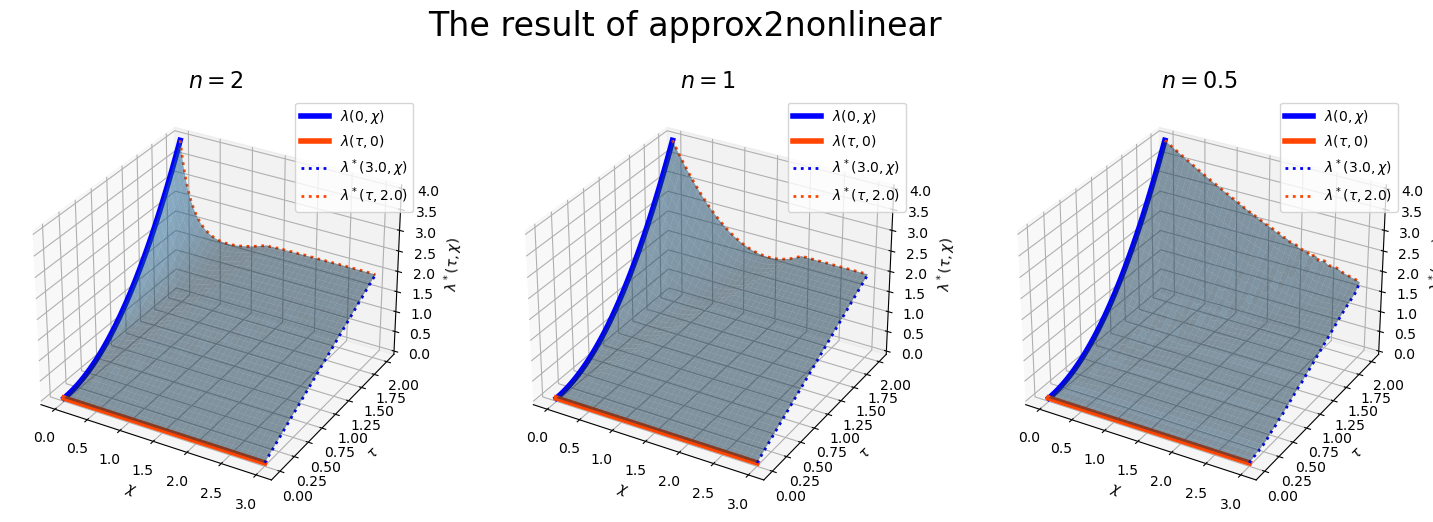

In [12]:
tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

fig, axs = plt.subplots(1, len(sols), subplot_kw={"projection": "3d"})
fig.set_figheight(6)
fig.set_figwidth(6*len(sols))

fig.suptitle(f'The result of {approx2nonlinear.__name__}', fontsize=24)

for i in range(len(ns)):
    title = f'$n = {ns[i]}$'
    
    axs[i].set_title(title, fontsize=16)
    
    axs[i].plot(0*chis, chis, initial(chis), linewidth=4, color='blue', label=r'$\lambda(0, \chi)$')
    axs[i].plot(taus, 0*taus, border(taus), linewidth=4, color='orangered', label=r'$\lambda(\tau, 0)$')
    
    axs[i].plot(tau_space[-1, :], chi_space[-1, :], sols[i, -1, :], 
                linestyle=':', linewidth=2, 
                color='blue', label=r'$\lambda^*({0}, \chi)$'.format(tau_space[-1, -1]))
    axs[i].plot(tau_space[:, -1], chi_space[:, -1], sols[i, :, -1], 
                linestyle=':', linewidth=2, 
                color='orangered', label=r'$\lambda^*(\tau, {0})$'.format(chi_space[-1, -1]))
    
    axs[i].plot_surface(tau_space, chi_space, sols[i], alpha=0.5)
    
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_ylabel(r'$\tau$')
    axs[i].set_zlabel(r'$\lambda^*(\tau, \chi)$')
    axs[i].legend()

# Approximation with 3 schemes

The approximation by previous scheme (let's call this scheme __square scheme__) needs nonlinear solver for each grid element. And this is too slow.

But there are ways to represent the new element directly in 6 grid points scheme.

## Vertical scheme
Here we will represent $\lambda^{j+1}_{k+1}$ in the terms of $\lambda^{j+1}_{k}, \lambda^{j}_{k}, \lambda^{j}_{k+1}, \lambda^{j-1}_{k}, \lambda^{j-1}_{k+1}$. 
The first we will represent these points as Taylor series near $(j\cdot s, (k+0.5)\cdot h)$:
$$
    \lambda^j_{k+1} = \lambda^j_{k+0.5} + 
    \cfrac{h}{2}\cdot(\cfrac{\partial\lambda}{\partial\chi})^j_{k+0.5} +
    \cfrac{h^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\chi^2})^j_{k+0.5} +
    O(h^3)
$$
$$
    \lambda^j_{k} = \lambda^j_{k+0.5} -
    \cfrac{h}{2}\cdot(\cfrac{\partial\lambda}{\partial\chi})^j_{k+0.5} +
    \cfrac{h^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\chi^2})^j_{k+0.5} +
    O(h^3)
$$
$$ 
    \lambda^{j+1}_{k+1} = \lambda^j_{k+0.5} +
    s\cdot(\cfrac{\partial\lambda}{\partial\tau})^j_{k+0.5} + 
    \cfrac{h}{2}\cdot(\cfrac{\partial\lambda}{\partial\chi})^j_{k+0.5} + 
    \cfrac{s^2}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^j_{k+0.5} + 
    \cfrac{sh}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau\partial\chi})^j_{k+0.5} + 
    \cfrac{h^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\chi^2})^j_{k+0.5} + 
    O(s^3 + h^3)
$$
$$ 
    \lambda^{j+1}_{k} = \lambda^j_{k+0.5} +
    s\cdot(\cfrac{\partial\lambda}{\partial\tau})^j_{k+0.5} - 
    \cfrac{h}{2}\cdot(\cfrac{\partial\lambda}{\partial\chi})^j_{k+0.5} + 
    \cfrac{s^2}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^j_{k+0.5} + 
    \cfrac{sh}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau\partial\chi})^j_{k+0.5} - 
    \cfrac{h^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\chi^2})^j_{k+0.5} + 
    O(s^3 + h^3)
$$
$$ 
    \lambda^{j}_{k+1} = \lambda^j_{k+0.5} -
    s\cdot(\cfrac{\partial\lambda}{\partial\tau})^j_{k+0.5} + 
    \cfrac{h}{2}\cdot(\cfrac{\partial\lambda}{\partial\chi})^j_{k+0.5} + 
    \cfrac{s^2}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^j_{k+0.5} -
    \cfrac{sh}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau\partial\chi})^j_{k+0.5} + 
    \cfrac{h^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\chi^2})^j_{k+0.5} + 
    O(s^3 + h^3)
$$
$$ 
    \lambda^{j}_{k} = \lambda^j_{k+0.5} -
    s\cdot(\cfrac{\partial\lambda}{\partial\tau})^j_{k+0.5} -
    \cfrac{h}{2}\cdot(\cfrac{\partial\lambda}{\partial\chi})^j_{k+0.5} + 
    \cfrac{s^2}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^j_{k+0.5} + 
    \cfrac{sh}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau\partial\chi})^j_{k+0.5} + 
    \cfrac{h^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\chi^2})^j_{k+0.5} + 
    O(s^3 + h^3)
$$

So we have 2nd order approximation of $\tau$-derivative:
$$
(\cfrac{\partial\lambda}{\partial\tau})^j_{k+0.5} \approx
\cfrac{\lambda^{j+1}_{k+1} + \lambda^{j+1}_{k} - \lambda^{j-1}_{k+1} - \lambda^{j-1}_{k}}{4s}
$$
and the line segmnet of 2nd order approximations of $\chi$-derivative:
$$
(\cfrac{\partial\lambda}{\partial\tau})^j_{k+0.5} \approx
a\cdot\cfrac{\lambda^j_{k+1} - \lambda^j_k}{h} + 
b\cdot 
\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j+1}_{k} + \lambda^{j-1}_{k+1} - \lambda^{j-1}_{k}}{4s}
$$
where $a+b = 1$. Let's set $a = 1$ and $b=0$.

Now we can put our  approximations to the equation
$$
\cfrac{\partial\lambda}{\partial\tau}(j\cdot s, (k+0.5)\cdot h) + 
(\cfrac{\partial\lambda}{\partial\chi}(j\cdot s, (k+0.5)\cdot h))^n - 
\nu(j\cdot s, (k+0.5)\cdot h) = 0
$$
and we will get
$$
\cfrac{\lambda^{j+1}_{k+1} + \lambda^{j+1}_{k} - \lambda^{j-1}_{k+1} - \lambda^{j-1}_{k}}{4s} + 
(\cfrac{\lambda^j_{k+1} - \lambda^j_k}{h})^n - \nu^j_{k+0.5} = 0
$$
Now we can represent $\lambda^{j+1}_{k+1}$ directly:
$$
\lambda^{j+1}_{k+1} = 
4s\cdot\nu^j_{k+0.5} - 
4s\cdot(\cfrac{\lambda^j_{k+1} - \lambda^j_k}{h})^n -
\lambda_k^{j+1} + \lambda_{k+1}^{j-1} + \lambda_k^{j-1}
$$

## Horizontal Scheme
Here we will represent $\lambda^{j+1}_{k+1}$ in the terms of $\lambda^{j+1}_{k-1}, \lambda^{j+1}_{k}, \lambda^{j}_{k-1}, \lambda^{j}_{k}, \lambda^{j}_{k+1}$. 
The first we will represent these points as Taylor series near $(j\cdot (s + 0.5), k\cdot h)$:
$$
\lambda^{j+1}_{k} = \lambda^{j + 0.5}_k + 
\cfrac{s}{2}\cdot(\cfrac{\partial\lambda}{\partial\tau})^{j+0.5}_k + 
\cfrac{s^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k + 
O(s^3)
$$
$$
\lambda^{j}_{k} = \lambda^{j + 0.5}_k -
\cfrac{s}{2}\cdot(\cfrac{\partial\lambda}{\partial\tau})^{j+0.5}_k + 
\cfrac{s^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k + 
O(s^3)
$$
$$
\lambda^{j+1}_{k+1} = \lambda^{j + 0.5}_k +
\cfrac{s}{2}\cdot(\cfrac{\partial\lambda}{\partial\tau})^{j+0.5}_k + 
h\cdot(\cfrac{\partial\lambda}{\partial\chi})^{j+0.5}_k + 
\cfrac{s^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k + 
\cfrac{sh}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau\chi})^{j+0.5}_k +
\cfrac{h^2}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k +  
O(s^3 + h^3)
$$
$$
\lambda^{j}_{k+1} = \lambda^{j + 0.5}_k -
\cfrac{s}{2}\cdot(\cfrac{\partial\lambda}{\partial\tau})^{j+0.5}_k + 
h\cdot(\cfrac{\partial\lambda}{\partial\chi})^{j+0.5}_k + 
\cfrac{s^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k -
\cfrac{sh}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau\chi})^{j+0.5}_k +
\cfrac{h^2}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k +  
O(s^3 + h^3)
$$
$$
\lambda^{j+1}_{k} = \lambda^{j + 0.5}_k +
\cfrac{s}{2}\cdot(\cfrac{\partial\lambda}{\partial\tau})^{j+0.5}_k -
h\cdot(\cfrac{\partial\lambda}{\partial\chi})^{j+0.5}_k + 
\cfrac{s^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k -
\cfrac{sh}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau\chi})^{j+0.5}_k +
\cfrac{h^2}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k +  
O(s^3 + h^3)
$$
$$
\lambda^{j}_{k} = \lambda^{j + 0.5}_k -
\cfrac{s}{2}\cdot(\cfrac{\partial\lambda}{\partial\tau})^{j+0.5}_k -
h\cdot(\cfrac{\partial\lambda}{\partial\chi})^{j+0.5}_k + 
\cfrac{s^2}{8}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k + 
\cfrac{sh}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau\chi})^{j+0.5}_k +
\cfrac{h^2}{2}\cdot(\cfrac{\partial^2\lambda}{\partial\tau^2})^{j+0.5}_k +  
O(s^3 + h^3)
$$

So we have 2nd order approximation of $\chi$-derivative:
$$
(\cfrac{\partial\lambda}{\partial\chi})^{j+0.5}_{k} \approx
\cfrac{\lambda^{j+1}_{k+1} + \lambda^{j}_{k+1} - \lambda^{j+1}_{k} - \lambda^{j}_{k}}{4h}
$$
and the line segmnet of 2nd order approximations of $\tau$-derivative:
$$
(\cfrac{\partial\lambda}{\partial\tau})^{j+0.5}_{k} \approx
a\cdot\cfrac{\lambda^{j+1}_{k+1} - \lambda^{j}_{k+1} + \lambda^{j+1}_{k} - \lambda^{j}_{k}}{2s} + 
b\cdot\cfrac{\lambda^{j+1}_k - \lambda^j_k}{s}
$$
where $a+b = 1$. Let's set $a = 0$ and $b=1$.

Now we can put our  approximations to the equation
$$
\cfrac{\partial\lambda}{\partial\tau}((j + 0.5)\cdot s, k\cdot h) + 
(\cfrac{\partial\lambda}{\partial\chi}((j + 0.5)\cdot s, k)\cdot h))^n - 
\nu((j + 0.5)\cdot s, k\cdot h) = 0
$$
and we will get
$$
\cfrac{\lambda^{j+1}_k - \lambda^j_k}{s} + 
(\cfrac{\lambda^{j+1}_{k+1} + \lambda^{j}_{k+1} - \lambda^{j+1}_{k} - \lambda^{j}_{k}}{4h})^n - 
\nu^{j + 0.5}_k = 0
$$
Now we can represent $\lambda^{j+1}_{k+1}$ directly:
$$
\lambda^{j+1}_{k+1} = 4h\cdot(\nu^{j + 0.5}_k - \cfrac{\lambda^{j+1}_k - \lambda^j_k}{s})^{1/n} - \lambda^j_{k+1} + \lambda^{j+1}_k + \lambda^j_k
$$

## The algorithm
We will seek solutions $\lambda^j_k$ over full grid in the following steps:

1. Find $\lambda^0_k$ and $\lambda^j_0$ due the boundary and initial conditions.
2. Find $\lambda^1_1$ by __square scheme__. This is the only moment, when we use nonlinear solver.
3. Find $\lambda^1_k$ by __horizontal schme__ (or $\lambda^j_1$ by __vertical scheme__).
4. Find other $\lambda^j_k$ by __vertical scheme__ (or by __horizontal scheme__, if we used __vertical scheme__ in previous step).

In [18]:
def get_element_by_vertical(subgrid, nu_val, n, dtau, dchi):
    """
    Returns subgrid[2, 1] goted by vertical scheme
    
    Parameters:
    -----------
    subgrid : float np.array shape (3, 2)
        sols[j-1:j+2, k:k+2]
    
    nu_val : float
        nu(j*dtau, (k + 0.5)*dchi)
        
    n : float
    
    dtau : float
    
    dchi : float
    
    Returns:
    --------
    res : float
    """
    res = 4*dtau*(nu_val - ((subgrid[1, 1] - subgrid[1, 0])/dchi)**n) - subgrid[2, 0] + subgrid[0, 1] + subgrid[0, 0]
    return res

In [35]:
def get_element_by_horizontal(subgrid, nu_val, n, dtau, dchi):
    """
    Returns subgrid[1, 2] goted by vertical scheme
    
    Parameters:
    -----------
    subgrid : float np.array shape (2, 3)
        sols[j:j+2, k-1:k+2]
    
    nu_val : float
        nu(j*dtau, (k + 0.5)*dchi)
        
    n : float
    
    dtau : float
    
    dchi : float
    
    Returns:
    --------
    res : float
    """
    res = 4*dchi*(nu_val - (subgrid[1, 1] - subgrid[0, 1])/dtau)**(1/n) - subgrid[0, 2] + subgrid[1, 1] + subgrid[0, 1]
    return res

In [136]:
def approx2by3schemes(nu, initial, border, n=1.0, dtau=1e-3, dchi=1e-3, ntau=200, nchi=1000, 
                      prioritet='horizontal', method=sp.optimize.fsolve, use_fprime=True, bar=None):
    """
    Returns the solution of equation
    $$
    \cfrac{\partial\lambda}{\partial\tau} = \nu(\chi, \tau) - (\cfrac{\partial\lambda}{\partial\chi})^n
    $$
    using 3 difference scheme:
    - Square scheme:
    $$
    \cfrac{1}{2s}(\lambda_{k+1}^{j+1} + \lambda_{k}^{j+1} - \lambda_{k}^{j+1} - \lambda_k^j) = 
    \nu((j+0.5)s, (k+0.5)h) - 
    (\cfrac{1}{2h}(\lambda_{k+1}^{j+1} - \lambda_{k}^{j+1} + \lambda_{k}^{j+1} - \lambda_k^j))^n + 
    O(s + h^n)
    $$
    - Vertical scheme:
    $$
    \lambda^{j+1}_{k+1} = 4s\cdot\nu^j_{k+0.5} - 4s\cdot(\cfrac{\lambda^j_{k+1} - \lambda^j_k}{h})^n - 
    \lambda_k^{j+1} + \lambda_{k+1}^{j-1} + \lambda_k^{j-1}
    $$
    - Horizontal Scheme:
    $$
    \lambda^{j+1}_{k+1} = 4h\cdot(\nu^{j + 0.5}_k - \cfrac{\lambda^{j+1}_k - \lambda^j_k}{s})^{1/n} - 
    \lambda^j_{k+1} + \lambda^{j+1}_j + \lambda^j_k
    $$
    
    
    
    Seek solutions $\lambda^j_k$ over full grid in the following steps:

    1. Find $\lambda^0_k$ and $\lambda^j_0$ due the boundary and initial conditions.
    2. Find $\lambda^1_1$ by __square scheme__. This is the only moment, when we use nonlinear solver.
    3. Find $\lambda^1_k$ by __horizontal schme__ (or $\lambda^j_1$ by __vertical scheme__).
    4. Find other $\lambda^j_k$ by __vertical scheme__ (or by __horizontal scheme__, if we used __vertical scheme__ in previous step).
    
    Parameters:
    -----------
    nu: function of 2 arguments
    
    initial: function of 1 argument
        lambda(chi) for tau = 0
        
    border: function of 1 argument
        lambda(tau), for chi = 0
        
    n : float
    
    dtau : float
    
    dchi : float
    
    ntau : int
        Number of tau grid lines
    
    nchi : int
        Number of chi grid lines
    
    prioritet : str, 'horizontal' or 'vertical'
        Which scheme should be the third? This scheme will calculate the most elements.
    
    method : function
        Method to solve nonlinear equation
        
    use_fprime : bool
        Use an analytical derivative as fprime parameter in method
        
    bar: tqdm bar or None:
        bar to update each iteration.
        Not draw bar if it's None
        
    Returns:
    --------
    sols: np.array shape (ntau, nchi)
        Solutions
    
    taus: np.array shape (ntau)
        tau values
        
    chis: np.array shape (nchis)
        chi values
    """
    if prioritet.lower() == 'horizontal':
        prioritet_horizontal = True
    elif prioritet.lower() == 'vertical':
        prioritet_horizontal = False
    else:
        raise ValueError(f"Unexpected prioritet value: {prioritet.__repr__()}\nShould be 'horizontal' or 'vertical'")
    
    taus = dtau*np.arange(ntau)
    chis = dchi*np.arange(nchi)
        
    
    # Find sol[0, :] and sol[:, 0] due the boundary and initial conditions.
    sols = np.zeros([ntau, nchi])
    try:
        sols[0, :] = initial(chis)
    except TypeError:
        sols[0, :] = [initial(chi) for chi in chis]
    try:
        sols[:, 0] = border(taus)
    except TypeError:
        sols[:, 0] = [border(tau) for tau in taus]
    
    # Find sol[1, 1] by square scheme. This is the only moment, when we use nonlinear solver.
    nu_val = nu(0.5*dtau, 0.5*dchi)
    f = lambda sol: 0.5*(sol + sols[1, 0] - sols[0, 1] - sols[0, 0])/dtau + (0.5*(sol - sols[1, 0] + sols[0, 1] - sols[0, 0])/dchi)**n - nu_val
    if use_fprime:
        fprime = lambda sol: 0.5/dtau + (0.5/dchi)*(0.5*(sol - sols[1, 0] + sols[0, 1] - sols[0, 0])/dchi)**(n - 1)
        fprime2 = lambda sol: (0.5/dchi)**2 * (0.5*(sol - sols[1, 0] + sols[0, 1] - sols[0, 0])/dchi)**(n - 2)
        try:
            sols[1, 1] = method(f, x0=sols[0, 0], fprime=fprime, fprime2=fprime2)
        except TypeError:
            sols[1, 1] = method(f, x0=sols[0, 0], fprime=fprime)
    else:
        sols[1, 1] = method(f, x0=sols[0, 0])
    if bar is not None:
        bar.update()
        
    # Find sol[:, 1] by vertical scheme, and sol[1, :] by horizontal schme
    for j in range(1, ntau - 1):
        nu_val = nu(1*dtau, 0.5*dchi)
        subgrid = sols[j-1: j+2, :2]
        sols[j + 1, 1] = get_element_by_vertical(subgrid, nu_val, n, dtau, dchi)
        if bar is not None:
            bar.update()
    for k in range(1, nchi - 1):
        nu_val = nu(1*dtau, (k + 0.5)*dchi)
        subgrid = sols[:2, k-1:k+2]
        sols[1, k+1] = get_element_by_horizontal(subgrid, nu_val, n, dtau, dchi)
        if bar is not None:
            bar.update()
                
    # Find sol[j, k] by vertical (or horizontal) scheme for j, k >= 2
    for j in range(1, ntau - 1):
        for k in range(1, nchi - 1):
            if prioritet_horizontal:
                nu_val = nu(dtau*(j + 0.5), dchi*k)
                subgrid = sols[j:j+2, k-1:k+2]
                sols[j+1, k+1] = get_element_by_horizontal(subgrid, nu_val, n, dtau, dchi)
            else:
                nu_val = nu(j*dtau, (k + 0.5)*dchi)
                subgrid = sols[j-1:j+2, k:k+2]
                sols[j+1, k+1] = get_element_by_vertical(subgrid, nu_val, n, dtau, dchi)
            if bar is not None:
                bar.update()

    return sols, taus, chis

In [137]:
prioritet = 'horizontal'

sols = []
for n in ns:
    print(f'Approximating over grid for n = {n}')
    with tqdm(total=(ntau - 1)*(nchi - 1)) as pbar:
        sol, taus, chis = approx2by3schemes(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, 
                                            bar=pbar, prioritet=prioritet)
    sols.append(sol.copy())

sols = np.array(sols)
sols.shape

Approximating over grid for n = 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Approximating over grid for n = 1


/tmp/ipykernel_56649/730860608.py:23: RuntimeWarning: overflow encountered in scalar power
  res = 4*dtau*(nu_val - ((subgrid[1, 1] - subgrid[1, 0])/dchi)**n) - subgrid[2, 0] + subgrid[0, 1] + subgrid[0, 0]
/tmp/ipykernel_56649/3348000571.py:23: RuntimeWarning: invalid value encountered in scalar power
  res = 4*dchi*(nu_val - (subgrid[1, 1] - subgrid[0, 1])/dtau)**(1/n) - subgrid[0, 2] + subgrid[1, 1] + subgrid[0, 1]
/tmp/ipykernel_56649/3348000571.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  res = 4*dchi*(nu_val - (subgrid[1, 1] - subgrid[0, 1])/dtau)**(1/n) - subgrid[0, 2] + subgrid[1, 1] + subgrid[0, 1]


  0%|          | 0/15000 [00:00<?, ?it/s]

Approximating over grid for n = 0.5


  0%|          | 0/15000 [00:00<?, ?it/s]

/tmp/ipykernel_56649/3348000571.py:23: RuntimeWarning: overflow encountered in scalar divide
  res = 4*dchi*(nu_val - (subgrid[1, 1] - subgrid[0, 1])/dtau)**(1/n) - subgrid[0, 2] + subgrid[1, 1] + subgrid[0, 1]


(3, 151, 101)

/usr/lib64/python3.11/site-packages/numpy/core/numeric.py:1670: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp


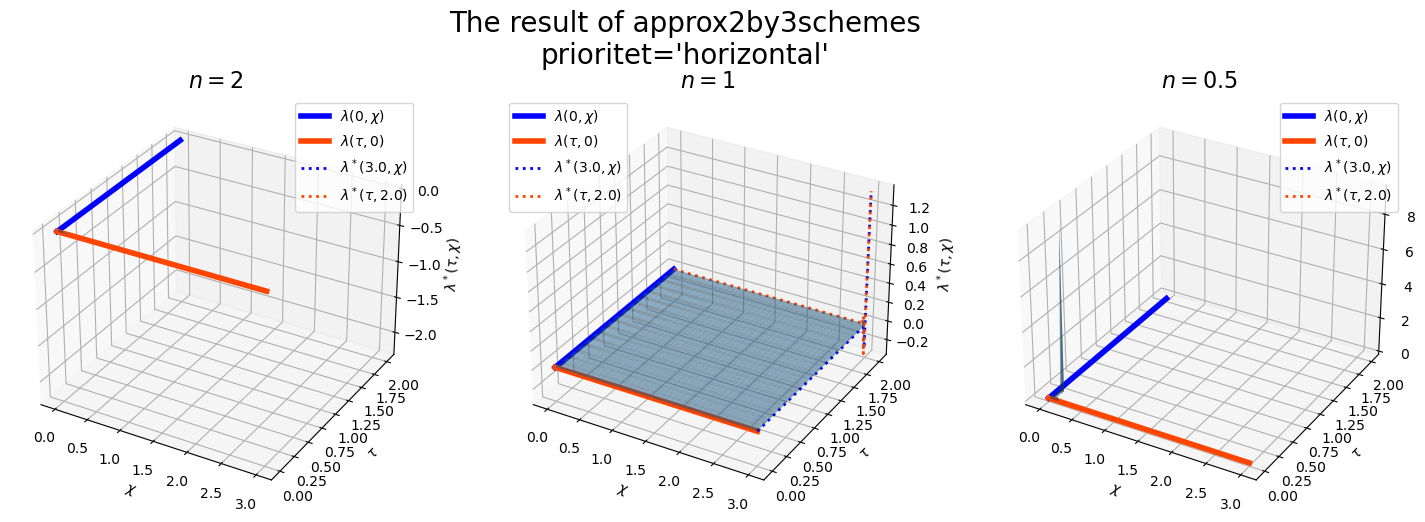

In [138]:
tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

fig, axs = plt.subplots(1, len(sols), subplot_kw={"projection": "3d"})
fig.set_figheight(6)
fig.set_figwidth(6*len(sols))

fig.suptitle(f'The result of {approx2by3schemes.__name__}\nprioritet={prioritet.__repr__()}', fontsize=20)

for i in range(len(ns)):
    title = f'$n = {ns[i]}$'
    
    axs[i].set_title(title, fontsize=16)
    
    axs[i].plot(0*chis, chis, initial(chis), linewidth=4, color='blue', label=r'$\lambda(0, \chi)$')
    axs[i].plot(taus, 0*taus, border(taus), linewidth=4, color='orangered', label=r'$\lambda(\tau, 0)$')
    
    axs[i].plot(tau_space[-1, :], chi_space[-1, :], sols[i, -1, :], 
                linestyle=':', linewidth=2, 
                color='blue', label=r'$\lambda^*({0}, \chi)$'.format(tau_space[-1, -1]))
    axs[i].plot(tau_space[:, -1], chi_space[:, -1], sols[i, :, -1], 
                linestyle=':', linewidth=2, 
                color='orangered', label=r'$\lambda^*(\tau, {0})$'.format(chi_space[-1, -1]))
    
    axs[i].plot_surface(tau_space, chi_space, sols[i], alpha=0.5)
    
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_ylabel(r'$\tau$')
    axs[i].set_zlabel(r'$\lambda^*(\tau, \chi)$')
    axs[i].legend()

In [140]:
prioritet = 'vertical'

sols = []
for n in ns:
    print(f'Approximating over grid for n = {n}')
    with tqdm(total=(ntau - 1)*(nchi - 1)) as pbar:
        sol, taus, chis = approx2by3schemes(nu, initial, border, n=n, dtau=dtau, dchi=dchi, ntau=ntau, nchi=nchi, 
                                            bar=pbar, prioritet=prioritet)
    sols.append(sol.copy())

sols = np.array(sols)
sols.shape

Approximating over grid for n = 2


  0%|          | 0/15000 [00:00<?, ?it/s]

Approximating over grid for n = 1


/tmp/ipykernel_56649/730860608.py:23: RuntimeWarning: overflow encountered in scalar power
  res = 4*dtau*(nu_val - ((subgrid[1, 1] - subgrid[1, 0])/dchi)**n) - subgrid[2, 0] + subgrid[0, 1] + subgrid[0, 0]
/tmp/ipykernel_56649/3348000571.py:23: RuntimeWarning: invalid value encountered in scalar power
  res = 4*dchi*(nu_val - (subgrid[1, 1] - subgrid[0, 1])/dtau)**(1/n) - subgrid[0, 2] + subgrid[1, 1] + subgrid[0, 1]


  0%|          | 0/15000 [00:00<?, ?it/s]

Approximating over grid for n = 0.5


  0%|          | 0/15000 [00:00<?, ?it/s]

/tmp/ipykernel_56649/730860608.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  res = 4*dtau*(nu_val - ((subgrid[1, 1] - subgrid[1, 0])/dchi)**n) - subgrid[2, 0] + subgrid[0, 1] + subgrid[0, 0]


(3, 151, 101)

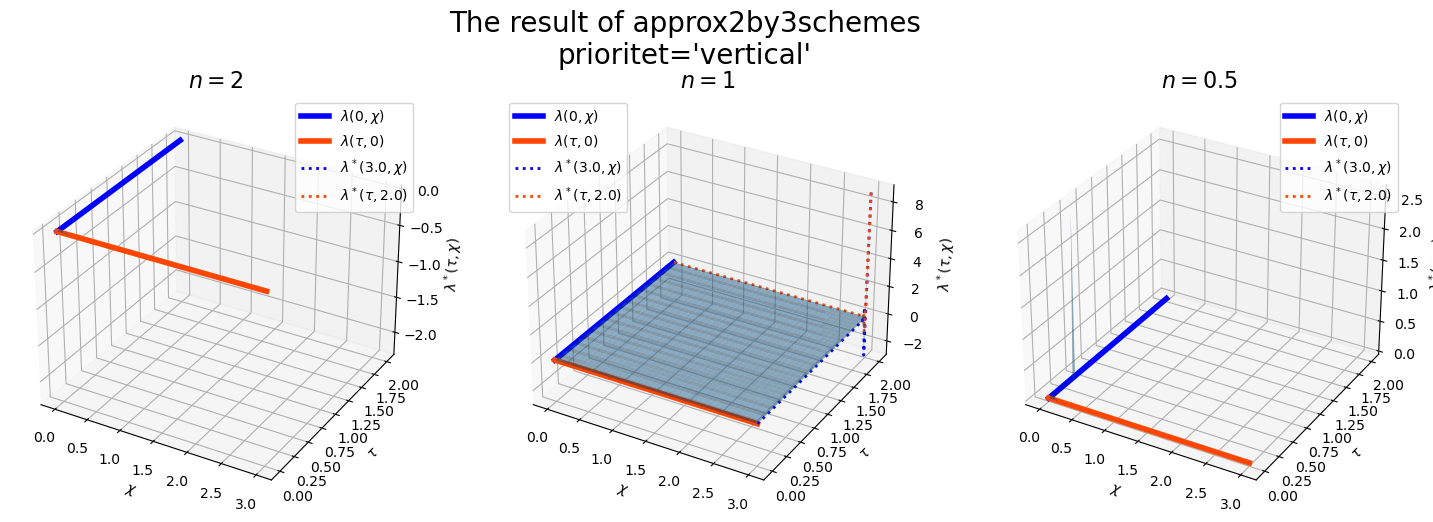

In [141]:
tau_space = np.ones([ntau, nchi])*taus.reshape([ntau, 1])
chi_space = np.ones([ntau, nchi])*chis.reshape([1, nchi])

fig, axs = plt.subplots(1, len(sols), subplot_kw={"projection": "3d"})
fig.set_figheight(6)
fig.set_figwidth(6*len(sols))

fig.suptitle(f'The result of {approx2by3schemes.__name__}\nprioritet={prioritet.__repr__()}', fontsize=20)

for i in range(len(ns)):
    title = f'$n = {ns[i]}$'
    
    axs[i].set_title(title, fontsize=16)
    
    axs[i].plot(0*chis, chis, initial(chis), linewidth=4, color='blue', label=r'$\lambda(0, \chi)$')
    axs[i].plot(taus, 0*taus, border(taus), linewidth=4, color='orangered', label=r'$\lambda(\tau, 0)$')
    
    axs[i].plot(tau_space[-1, :], chi_space[-1, :], sols[i, -1, :], 
                linestyle=':', linewidth=2, 
                color='blue', label=r'$\lambda^*({0}, \chi)$'.format(tau_space[-1, -1]))
    axs[i].plot(tau_space[:, -1], chi_space[:, -1], sols[i, :, -1], 
                linestyle=':', linewidth=2, 
                color='orangered', label=r'$\lambda^*(\tau, {0})$'.format(chi_space[-1, -1]))
    
    axs[i].plot_surface(tau_space, chi_space, sols[i], alpha=0.5)
    
    axs[i].set_xlabel(r'$\chi$')
    axs[i].set_ylabel(r'$\tau$')
    axs[i].set_zlabel(r'$\lambda^*(\tau, \chi)$')
    axs[i].legend()

__Conclusion:__ something is wrong here. Maybe, I made some arythmetic mistake, or the scheme is not stable.